# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory.
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

## Imports

In [17]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [18]:
from torchvision import datasets
from torch.utils.data import DataLoader
# Define transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to Tensor
    transforms.Normalize((0.5,), (0.5,))
])

# Create training set and define training dataloader
training_data = datasets.MNIST(root ="data", train= True, download =True, transform = transform)
train_loader = DataLoader(training_data, batch_size= 32, shuffle= True)
# Create test set and define test dataloader
test_data = datasets.MNIST(root ="data", train= False, download =True, transform = transform)
test_loader = DataLoader(test_data, batch_size= 32)

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [19]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.figure(figsize=(1, 1))
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [20]:
print(f"Amount of training samples:  + {len(training_data)}")
images, labels = next(iter(train_loader))
print(f"Image shape: {images.shape[1:]}")

Amount of training samples:  + 60000
Image shape: torch.Size([1, 28, 28])


5


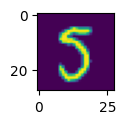

5


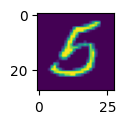

8


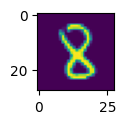

5


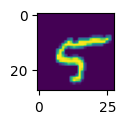

9


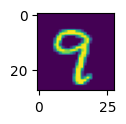

In [21]:
# Explore data

show5(train_loader)

## Improving your model



## Adding function

In [1]:
def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
    """Add title xlabel and legend to single chart"""
    ax.set_title(group_name)
    ax.set_xlabel(x_label)
    ax.legend(loc="center right")

    if group_name.lower() == "loss":
        ax.set_ylim([None, 4.5])


NameError: name 'plt' is not defined

## Data prepocessing

In [24]:
import os
from tqdm import tqdm

def compute_mean_and_std_mnist():
    """
    Compute mean and std of the MNIST dataset.
    """

    cache_file = "mean_and_std_mnist.pt"
    if os.path.exists(cache_file):
        print(f"Reusing cached mean and std for MNIST")
        d = torch.load(cache_file)
        return d["mean"], d["std"]

    # Load the MNIST dataset without any transformations first
    ds = datasets.MNIST(root="data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
    dl = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=0)

    mean = 0.0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing mean", ncols=80):
        mean += images.mean()

    mean /= len(ds)

    var = 0.0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing std", ncols=80):
        var += ((images - mean) ** 2).sum()

    std = torch.sqrt(var / len(ds))

    # Cache results so we don't need to redo the computation
    torch.save({"mean": mean, "std": std}, cache_file)

    return mean, std


In [25]:
from torch.utils.data import random_split

mean, std = compute_mean_and_std_mnist()
# Simple Augmentation for simple data set 28x28
# convert data to a normalized torch.FloatTensor
transforms_train = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5), (0.5))]
)

transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Small rotations, translations, and scaling
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

# Create training set and define training dataloader
training_data_CNN = datasets.MNIST(root="data", train=True, download=True, transform=transforms_train)
train_loader_CNN = DataLoader(training_data_CNN, batch_size=256, shuffle=True)

# Create test set and define test dataloader
test_data_CNN = datasets.MNIST(root="data", train=False, download=True, transform=transforms_train)
test_loader_CNN = DataLoader(test_data_CNN, batch_size=32)

# Splitting the test dataset into validation and 'new' test sets
val_size = int(0.5 * len(test_data_CNN))
test_size = len(test_data_CNN) - val_size

val_data, new_test_data = random_split(test_data_CNN, [val_size, test_size])

val_loader_CNN = DataLoader(val_data, batch_size=32)
new_test_loader_CNN = DataLoader(new_test_data, batch_size=32)

Reusing cached mean and std for MNIST


## CNN Model

In [26]:
class BetterNet(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.25) -> None:
        super(BetterNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   # 28x28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),       #32x 14x14
            nn.Dropout2d(dropout),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),       #64x7x7
            nn.Dropout2d(dropout),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate the model
net = BetterNet()

In [27]:
optimizer = optim.Adam(net.parameters(), lr=0.0005)
# optimizer =optim.SGD(net.parameters(), lr = 0.01, momentum =0.9)

criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)


BetterNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.25, inplace=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout2d(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=1024, bias=True)
    (1): ReLU()
    (2): Batch

In [28]:
# # Load Saving if shut down
# model = net

# checkpoint = torch.load('checkpoint.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch'] + 1


In [29]:
!pip install livelossplot

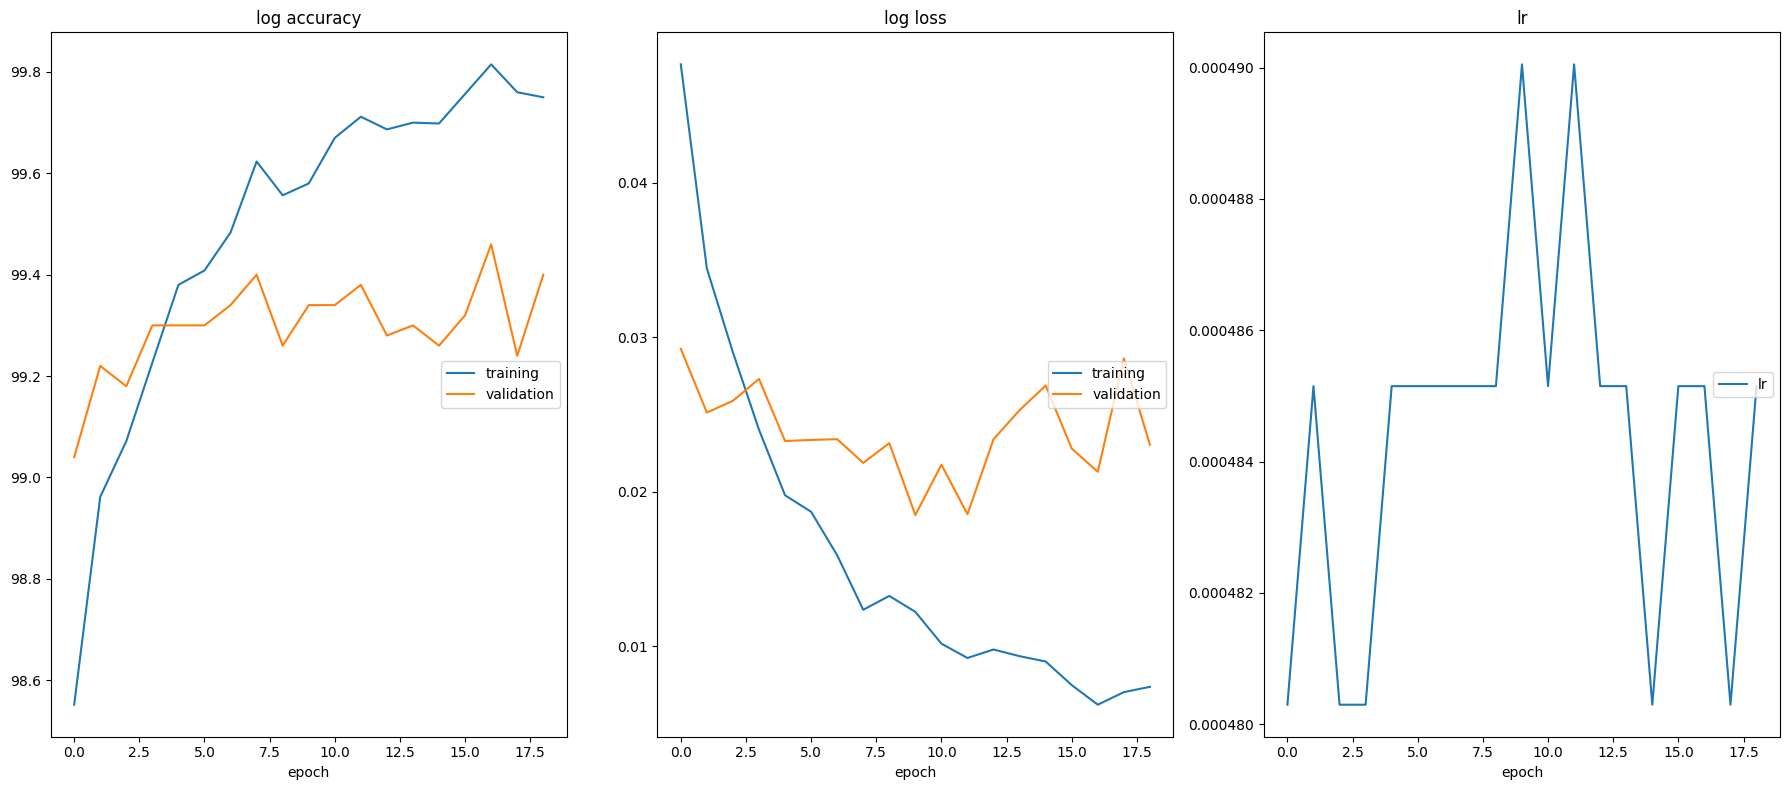

Epoch 20 Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20 Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Early stopping!


In [31]:

from tqdm.notebook import tqdm  # For progress bars
import matplotlib.pyplot as plt  # For plotting
from IPython.display import clear_output  # To update plots dynamically
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
import matplotlib
model = net

num_epochs = 400  # or however many you need
best_val_loss = float('inf')
no_improve_epochs = 0
patience = 10
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
matplotlib.rcParams['figure.figsize'] = [15, 5]

liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot, max_cols=3)])

logs = {}

# Check if 'epoch' key exists in the checkpoint, otherwise set to 0
# start_epoch = checkpoint.get('epoch', 0) + 1
start_epoch = 0

milestones = [epoch for epoch in range(1, 501)]
gamma = 0.99 # Assuming you want to multiply the learning rate by 0.99 every epoch

#Inspiration from Ciresan et al., 2011
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

for epoch in range(start_epoch, num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0

    for inputs, labels in tqdm(train_loader_CNN, desc=f"Epoch {epoch + 1} Training"):
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()

    train_loss_history.append(train_loss/len(train_loader_CNN))
    train_acc_history.append(100 * train_correct/len(training_data_CNN))

    val_loss = 0.0
    val_correct = 0
    net.eval()

    for inputs, labels in tqdm(val_loader_CNN, desc=f"Epoch {epoch + 1} Validation"):
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()

    val_loss_history.append(val_loss/len(test_loader_CNN))
    val_acc_history.append(100 * val_correct/len(test_data_CNN))

    # Update the learning rate based on the validation loss
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # ... any other data you wish to save ...
}
        torch.save(checkpoint, 'checkpoint.pth')
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= patience:
        print("Early stopping!")
        break

    # Log the losses for the live plot
    logs["log loss"] = train_loss / len(train_loader_CNN)
    logs["val_log loss"] = val_loss / len(val_loader_CNN)
    logs["log accuracy"] = 100 * train_correct/len(training_data_CNN)
    logs["val_log accuracy"] = (100 * val_correct/val_size)
    logs["lr"] = optimizer.param_groups[0]["lr"]

    liveloss.update(logs)
    liveloss.send()

In [32]:
# checkpoint = torch.load('checkpoint.pth')
# net.load_state_dict(checkpoint['model_state_dict'])
net.eval()
correct = 0
total = 0

with torch.no_grad():  # Deactivate gradients for the following code
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    for data in new_test_loader_CNN:
        images, labels = data
        if torch.cuda.is_available():
          images, labels = images.cuda(), labels.cuda()

        # Forward pass
        outputs = net(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)  # Increment the total count
        correct += (predicted == labels).sum().item()  # Increment correct count

# Calculate the accuracy
new_accuracy = 100 * correct / total
print(f'Accuracy of the network on test images: {new_accuracy:.2f}%')

Accuracy of the network on test images: 99.32%


## Saving your model
Using `torch.save`, save your model for future loading.

In [34]:
torch.save(net.state_dict(), 'best_model_cnn_99.32.pt')